**MO-BOLFI**

The notebook presents an implementation of Multi-objective BOLFI algorithm (arxiv link)
The dataset used is self-collected data for psychology analysis in decision-making (description here).
Feel free to contact e1039688@u.nus.edu if you have any question regarding the paper and the codes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from scipy.optimize import minimize

In [ ]:
df = pd.read_csv("empirical_data.csv")
df.head(5)


,Unnamed: 0,ID,Scenario,alt,chosen,RC,OC,DR,CT,WT,...,AT4_1,AT4_2,AT4_3,nationality,Gender,marital,age,experience_months,income,education
0,0,R_3fZBQYRcTj6rtUC,IND1.3,1,1,3000,45,550,11.5,NaN,...,3.0,2.0,2.0,4.0,2.0,1.0,68.0,300.0,1.5,2.0
1,1,R_3fZBQYRcTj6rtUC,IND1.3,3,0,3900,14,350,18,NaN,...,3.0,2.0,2.0,4.0,2.0,1.0,68.0,300.0,1.5,2.0
2,2,R_3fZBQYRcTj6rtUC,IND1.2,1,1,3000,45,550,11.5,NaN,...,3.0,2.0,2.0,4.0,2.0,1.0,68.0,300.0,1.5,2.0
3,3,R_3fZBQYRcTj6rtUC,IND1.2,3,0,3600,14,350,18,NaN,...,3.0,2.0,2.0,4.0,2.0,1.0,68.0,300.0,1.5,2.0
4,4,R_3fZBQYRcTj6rtUC,IND1.1,1,1,3000,45,550,11.5,NaN,...,3.0,2.0,2.0,4.0,2.0,1.0,68.0,300.0,1.5,2.0


**Data Preprocessing**

We use all the A and S scenarios. There are 320 observations in the scenarios we use. Each observation represents a candidate answered a question "Which one would you like to choose?" under A1.1 from 3 alternatives (denoted as 1, 3, 4 respectively in raw data), given 3 attributes values for each alternative. The final choice made and fixation trail of each candidate are recorded.


3 attributes:

RC - Renting cost (per month)

OC - Operating cost (per day)

DR - Driving range


The outcome from candidates are fixation_trail and choice. Fixation_trail is the aggregated time of fixation during the scenario. The choice is the final chosen alternative of the candidate.

In [3]:
# define hyper params

number_of_alternatives = 3
number_of_attributes = 2
number_of_discrepancies = 1


In [4]:
# Add data scenarios one by one for convenient adding & deleting new data
df_data = df[df.Scenario == "A1.1"]
df_data = pd.concat([df_data, df[df.Scenario == "A1.1R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.2"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.2R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.3"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.3R"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.4"]],axis=0)
df_data = pd.concat([df_data, df[df.Scenario == "A1.4R"]],axis=0)




# Standardize attributes data
# There are 3 attributes RC OC DR CT
# Response time column: fixation trail
 
df_data.drop(df_data[(df_data.ID=="R_2xESOZsu1b0DK9W")|(df_data.ID=="R_1kUrkeP2G5SzhZ9")|(df_data.ID=="R_3MLEPJF4WwO69ZI")|(df_data.ID=="R_28O4cGfWMqm0fkg")|(df_data.ID=="R_3lMIUHexfItTFyN")|(df_data.ID=="R_3HohVlDFTj1gqWK")].index,inplace= True)


#  remove observations whose RT is outlier

rt_mean = np.mean(df_data.time)

rt_std =  np.std(df_data.time)


df_data.drop(df_data[(df_data.time<np.max([0,(rt_mean-3*rt_std)]))|(df_data.time>(rt_mean+3*rt_std))].index,inplace= True)

df_data.head(5)

,Unnamed: 0,ID,Scenario,alt,chosen,RC,OC,DR,CT,WT,...,AT4_1,AT4_2,AT4_3,nationality,Gender,marital,age,experience_months,income,education
208,208,R_1MMyGP7w3EwTfMC,A1.1,1,0,3000,41,600,13,NaN,...,1.0,2.0,2.0,4.0,2.0,1.0,45.0,96.0,2.5,3.0
209,209,R_1MMyGP7w3EwTfMC,A1.1,3,1,3000,17,350,22,NaN,...,1.0,2.0,2.0,4.0,2.0,1.0,45.0,96.0,2.5,3.0
210,210,R_1MMyGP7w3EwTfMC,A1.1,4,0,2950,17,250,31,NaN,...,1.0,2.0,2.0,4.0,2.0,1.0,45.0,96.0,2.5,3.0
430,430,R_1I4bJytxmiu84aS,A1.1,1,0,3000,23,850,5.5,NaN,...,2.0,2.0,2.0,4.0,2.0,1.0,55.0,156.0,2.5,3.0
431,431,R_1I4bJytxmiu84aS,A1.1,3,0,3000,14,500,9,NaN,...,2.0,2.0,2.0,4.0,2.0,1.0,55.0,156.0,2.5,3.0


In [5]:
# RC & OC & DR
X_matrix = np.array(df_data[["RC","OC","DR","Freq_p_week"]].astype("float64"))

# RC, OC are expected to be small, DR is expected to be large
# Transform the columns RC OC to unify the direction of optimization
# totoal cost
X_matrix[:,0] = -X_matrix[:,0]-X_matrix[:,1]*X_matrix[:,3]*52/12

X_matrix[:,2] = X_matrix[:,2]

X_matrix[:,0] = (X_matrix[:,0]-X_matrix[:,0].min())/(X_matrix[:,0].max()-X_matrix[:,0].min())

X_matrix[:,2] = (X_matrix[:,2]-X_matrix[:,2].min())/(X_matrix[:,2].max()-X_matrix[:,2].min())

X_attributes = pd.DataFrame(np.take(X_matrix, [0,2], axis = 1))


X_attributes = pd.DataFrame(X_attributes.values.reshape(X_attributes.shape[0]//number_of_alternatives, number_of_attributes*number_of_alternatives),
                    columns=['TC1','DR1', 'TC3','DR3', 'TC4', 'DR4']) 

# X_attributes

X_attributes2 = pd.DataFrame(np.take(np.array(X_attributes),[0,1,2,3],axis = 1),
                             columns=['TC1','DR1', 'TC3','DR3'])
print(X_attributes2)

          TC1       DR1       TC3       DR3
0    0.281256  0.615385  0.492271  0.230769
1    0.497295  1.000000  0.553816  0.461538
2    0.680580  0.615385  0.861449  0.230769
3    0.751884  0.923077  0.833527  0.461538
4    0.652367  1.000000  0.727729  0.461538
..        ...       ...       ...       ...
579  0.532077  0.769231  0.758164  0.307692
580  0.576329  0.692308  0.840097  0.307692
581  0.290048  0.769231  0.465894  0.307692
582  0.748406  0.615385  0.848696  0.230769
583  0.590145  0.538462  0.884058  0.230769

[584 rows x 4 columns]


In [6]:
# The response data
# X_response = df_data[["ID","alt","chosen","fixation_trail"]] # for lab dataset
X_response = df_data[["ID","alt","chosen","time"]] # for online dataset
# Change milsecond to second


X_response[["time"]] = X_response[["time"]] # for online dataset

X_response["chosen1"] = 1*(X_response['chosen']==1)*(X_response["alt"]==1)
X_response["chosen3"] = 1*(X_response['chosen']==1)*(X_response["alt"]==3)
X_response["chosen4"] = 1*(X_response['chosen']==1)*(X_response["alt"]==4)


X_response = X_response.drop(columns=["alt","chosen"])

condition_chosen = X_response[(X_response['chosen1']==0) & (X_response['chosen3']==0) & (X_response['chosen4']==0)].index
X_response = X_response.drop(condition_chosen)

C:\Users\e0729936\AppData\Local\Temp\ipykernel_36656\1428476389.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_response[["time"]] = X_response[["time"]] # for online dataset
C:\Users\e0729936\AppData\Local\Temp\ipykernel_36656\1428476389.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_response["chosen1"] = 1*(X_response['chosen']==1)*(X_response["alt"]==1)
C:\Users\e0729936\AppData\Local\Temp\ipykernel_36656\1428476389.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [7]:
X_attributes.shape

(584, 6)

In [8]:
X_response.describe()

,time,chosen1,chosen3,chosen4
count,584.000000,584.000000,584.000000,584.000000
mean,11.468971,0.410959,0.450342,0.138699
std,11.384608,0.492430,0.497955,0.345928
min,1.021000,0.000000,0.000000,0.000000
25%,4.238250,0.000000,0.000000,0.000000
50%,7.764500,0.000000,0.000000,0.000000
75%,14.319750,1.000000,1.000000,0.000000
max,68.911000,1.000000,1.000000,1.000000


**MLBA Simulator**

This section defines a simulator model that generates outcomes (fixation_trail, choice) given a set of parameter values and attributes data. The model refers to *[Hancock et al, 2021](https://www.sciencedirect.com/science/article/abs/pii/S0191261521000576)*.


For Citation: Hancock, Thomas O., et al. "An accumulation of preference: two alternative dynamic models for understanding transport choices." Transportation Research Part B: Methodological 149 (2021): 250-282.

In [9]:
def create_distance_matrix(row, number_of_alternatives,number_of_attributes):
    rows = row.values.reshape(number_of_alternatives,-1)
    distance_matrix = np.zeros((number_of_alternatives,number_of_alternatives,number_of_attributes))
    for i in range(number_of_alternatives):
      for j in range(number_of_alternatives):
        distance_matrix[i,j,:] = rows[i,:]-rows[j,:]

    return distance_matrix

# Test using first row (obs) of the data
create_distance_matrix(X_attributes.iloc[0,:],number_of_alternatives,number_of_attributes)

array([[[ 0.        ,  0.        ],
        [-0.21101449,  0.38461538],
        [-0.22550725,  0.53846154]],

       [[ 0.21101449, -0.38461538],
        [ 0.        ,  0.        ],
        [-0.01449275,  0.15384615]],

       [[ 0.22550725, -0.53846154],
        [ 0.01449275, -0.15384615],
        [ 0.        ,  0.        ]]])

In [10]:
distance_matrix = create_distance_matrix(X_attributes.iloc[0,:],number_of_alternatives,number_of_attributes)

distance_matrix[2,0:2,0]

array([0.22550725, 0.01449275])

In [11]:
test_matrix = np.zeros((2,len(X_attributes)))
for i in range(len(X_attributes)):
    test_matrix[:,i] =  create_distance_matrix(X_attributes.iloc[i,:],number_of_alternatives,number_of_attributes)[1,0:2,1]
    
    
pd.DataFrame(test_matrix.transpose()).describe()

,0,1
count,584.000000,584.0
mean,-0.428214,0.0
std,0.061396,0.0
min,-0.538462,0.0
25%,-0.461538,0.0
50%,-0.461538,0.0
75%,-0.384615,0.0
max,-0.307692,0.0


In [12]:
def compute_mean_drift_rate(X_attributes,lambdas,log_I0,betas,deltas):
    number_of_alternatives = len(deltas)+1
    number_of_candidates = int(X_attributes.shape[0])
    means = np.zeros((X_attributes.shape[0], number_of_alternatives))
    lambda0, lambda1 = lambdas[0], lambdas[1]
  
    for n in range(number_of_candidates):
        attributes_n = X_attributes.iloc[n,:] # attributes of individual n
        distance_matrix = create_distance_matrix(attributes_n, number_of_alternatives, number_of_attributes)
        Lambda = np.where(distance_matrix>0,lambda0,lambda1)
        Beta = np.repeat(np.repeat(np.array(betas).reshape(1,-1),number_of_alternatives,axis=0),number_of_alternatives,axis=0).reshape(-1,number_of_alternatives,number_of_attributes)
        weight_temp = -1*np.multiply(Lambda,np.multiply(Beta,np.absolute(distance_matrix)))
        
        weight_temp = np.where(weight_temp<50, weight_temp, 50)
        weight_temp = np.where(weight_temp>-50, weight_temp, -50)
        
  
        weights_matrix = np.exp(weight_temp)
        V_n = np.multiply(weights_matrix,np.multiply(Beta,distance_matrix))
        V_n = np.sum(np.sum(V_n,axis=2),axis=1)
        delta1 = np.zeros((1,1))
        Delta = np.concatenate((np.array(deltas).reshape(1,-1),delta1),axis=1) # set the last alternative as reference
        V_n = V_n + Delta + np.exp(log_I0)
        # the mean drift rate is non-negative
        means[n,:] = np.where(V_n>0, V_n, 0) # the mean drift rate is non-negative

    return means

In [13]:
#Test
means = compute_mean_drift_rate(X_attributes,lambdas=[0.1,0.2],log_I0=np.log(1),
                        betas=[2,0.12],deltas=[-0.2,22])
means

array([[ 0.11015874, 23.3484685 ,  1.37784737],
       [ 0.69802113, 23.03759659,  1.06882616],
       [ 0.21229414, 23.29276721,  1.32247485],
       ...,
       [ 0.26275216, 23.29162278,  1.27074802],
       [ 0.51408929, 23.15772694,  1.1371211 ],
       [ 0.        , 23.52447683,  1.50295826]])

In [14]:
means.shape

# (1208,3)

(584, 3)

In [15]:
import scipy.stats

def MLBA(X_attributes, lambdas,log_I0,  betas, deltas, threshold, A = 48, s=1 ):
    """
    MLBA simulator
    input: parameters that are derectly used in MLBA model & data X
    output: choice outcome and response time
    Details:
    A:starting point upper bound such that start points of accumulators will follow this Unif(0,A).
    threshold: threshold is the boundary which reaches the first accumulator(final choice), here actually is log(threshold-A) 
    X_response: Choice made and coresponding response time of candidates
    s: common sd of N(u_n, s), the drift rate of the ith accumulator d_n~N(u_n, s)
    u_n: mean values u_n, computed from compute_mean_drift_rate() for individual n

    """

    number_of_candidates = int(X_attributes.shape[0])
    
########################## 
    threshold = np.exp(threshold)+A
    betas = np.exp(betas)
    # lambdas = np.exp(lambdas)

   
    number_of_alternatives = len(deltas)+1
    # Initialize the accumulators and the starting point
    accumulators = np.zeros((number_of_candidates,number_of_alternatives))
    start_points = np.random.uniform(low=0, high=A, size=(number_of_candidates,number_of_alternatives))
    accumulators = accumulators + start_points

    # Compute the mean of normals that drift rate follows for each accumulator
    means = compute_mean_drift_rate(X_attributes, lambdas, log_I0, betas, deltas)
    drift_rates = means
    # print(means)
    for i in range(number_of_candidates):
        for j in range(number_of_alternatives):
            drift_rates[i,j] = scipy.stats.truncnorm.rvs(a = (0- means[i,j])/s, b = (400- means[i,j])/s , loc= means[i,j], scale=s).item() 
            # here to only draw non-negative drift rate so that no need for the non-negative drift rate check in the following
    # print(drift_rates)
    # drift_rates = means + np.random.standard_normal(size=(number_of_candidates,number_of_alternatives)) * s

    # here to only include non-native sampler

    # For each candidate, run the mlba simulation game
    rt = np.zeros(number_of_candidates)
    choice = np.zeros((number_of_candidates,number_of_alternatives))
    for n in range(number_of_candidates):
        accumulators_n = accumulators[n,:]
        drift_rates_n = drift_rates[n,:]
        rt_candidate = (threshold-start_points[n,:])/drift_rates_n
        choice_n = np.argmin(rt_candidate)
        choice[n,choice_n] = 1
        rt[n] = rt_candidate[choice_n]

    return (rt,choice)

In [16]:
#Test
MLBA(X_attributes,lambdas=[0.1,0.2],log_I0=np.log(10),
                        betas=[1,0.5],deltas=[-10,-0.3], threshold=5)

(array([15.15360049, 15.69590272, 16.73124863, 19.19627117, 17.49004862,
        16.08754689, 17.70260547, 15.0295363 , 20.42883068, 16.66568332,
        13.52245648, 18.44968093, 17.82828981, 18.11027857, 19.62975943,
        14.85511368, 18.14468099, 16.22993195, 15.89209402, 16.86739186,
        20.37790972, 18.61182168, 18.2120293 , 17.29109391, 15.01883274,
        19.24597304, 20.82669342, 16.02657385, 18.33977199, 19.20628558,
        16.83352182, 18.06937248, 14.99689924, 20.28569957, 15.46364339,
        16.47049932, 18.96399579, 15.75735259, 17.17329641, 19.21258633,
        16.22645223, 15.52667563, 17.71796287, 17.73740559, 13.35713972,
        19.88730992, 17.87768497, 15.25310209, 16.34297664, 17.76936812,
        14.96699875, 13.64849434, 16.49962399, 17.0290843 , 16.06434162,
        16.47746927, 19.19489634, 15.10418557, 18.51499789, 16.98333218,
        15.71652334, 15.60796561, 15.72850578, 18.51289636, 13.66526431,
        16.80220379, 15.7640122 , 16.21478655, 14.6

***Optional: Define discrepancies between some summary statistics on simulated and observed data. Currently the raw rt & choice data is viewed as summary statistics on itself. Given the possible multimodal posterior of parameters of MLBA, using raw data (with no infor loss) might be the safe strategy in this case.***

In [17]:
def per_sample(raw,theta,X_response_rt,nObs):
    lambdas, log_I0, betas, deltas, threshold = theta
    (rt_sim,choice_sim) = MLBA(X_attributes, lambdas, log_I0, betas, deltas, threshold)

    tmp_rt =np.mean(np.abs(np.log(np.sort(X_response_rt))-np.log(np.sort(rt_sim))))/3
    tmp_ch = choice_sim.mean(axis=0)
    
 
    return([ tmp_rt,tmp_ch])

In [18]:
from joblib import Parallel, delayed


def minus_simluated_discrepancy(theta, X_response=X_response, X_attributes=X_attributes):
    """
    X_response: Observed choice and coresponding response time of candidates
    X_attributes: standardized data of attributes of alternatives, used for compute mean value of normals that drift rates follow
    Each row of X is an individual-specific alternvative's attributes
    theta: a vector of all parameters, orderly including (lambdas, log_I0, betas, deltas, log_(threshold-A))
    output: distance between simulated choice & resposne time and observed choice & response time
    We take log of I0 and threshold because they are positive numbers, taking log maps them to the whole real line, which is approporaite for prior definition and MCMC
    """
    
   
   # Observed data
    X_response_rt = X_response[["time"]].values
    X_response_choice = X_response[["chosen1","chosen3","chosen4"]].values

    # lambdas, log_I0, betas, deltas, threshold = theta
    X_response_rt = X_response_rt.reshape(-1)
    
    nObs = len(X_response)

    # Simulation discrepancy (take log of rt discrepancy)
    # iter_n replicate number
    iter_n = 50
    discrepancies = np.zeros((1,number_of_discrepancies)) # 2 discrepancies
    X_response_ch = np.array(X_response_choice.mean(axis = 0))

    
    res =pd.DataFrame(Parallel(n_jobs = 20)(delayed(per_sample)(row,theta,X_response_rt,nObs) for row in range(iter_n)),columns=["RT","CH"])

    
    dis_1_tes = np.mean(res.RT)
    discrepancy_rt = np.where(dis_1_tes >1e-5,np.log(dis_1_tes),np.log(1e-5))
 
    choice_candidate = np.array(res.CH.to_list()).reshape((iter_n,number_of_alternatives))
    dis_2_tes = np.mean(( choice_candidate-X_response_ch)**2,axis=0).sum()
    discrepancy_choice = np.where(dis_2_tes >1e-5,np.log(dis_2_tes),np.log(1e-5))
    discrepancies[0,:] = discrepancy_rt + discrepancy_choice
    


    return discrepancies*-1


In [19]:
minus_simluated_discrepancy(theta=([0.1,0.2], np.log(0.5), [0.2,0.12], [-10,0.1],np.log(70)))

array([[3.45386074]])

MO-BOLFI is a likelihood-free inference method that effectively surrogates simulators like MLBA model. **We'll show that it can surrogate MLBA and generate data highly similar with the MLBA-simulated data.**

Thus, instead of using X_response, we'll generate "real response" by simulated dataset given a self-defined "real parameter".

The real parameter is chosen to be a proper value that simulates stable, well distributed "real resposne". Random choice of real parameter may make real resposne a bad data in model fitting (e.g. a dataset with all candidates choosing the same alternative)

In the rest of this notebook, the "real_response" we generated in the following chunk will be viewed as the real data.



In [20]:
#  CF MAP value
real_theta  = [9.404336e-02 ,0,0,-8.758533e-01,0,2.080699e+00,1.414022e+00,  6.108216e-01] # DR
real_theta 

[0.09404336, 0, 0, -0.8758533, 0, 2.080699, 1.414022, 0.6108216]

In [21]:
real_data = MLBA(X_attributes,lambdas=real_theta[0:2], log_I0=real_theta[2],
                    betas=real_theta[3+number_of_alternatives-1:3+number_of_attributes+number_of_alternatives-1],
                    deltas=real_theta[3:3+number_of_alternatives-1],
                    threshold= real_theta[-1])

real_response = pd.DataFrame(real_data[1], columns=["chosen1", "chosen3", "chosen4"])
real_response = pd.concat([pd.DataFrame(real_data[0], columns = ["time"]), real_response],axis=1)

In [22]:
real_response.describe() # closed-form


,time,chosen1,chosen3,chosen4
count,584.000000,584.000000,584.000000,584.000000
mean,12.819678,0.482877,0.339041,0.178082
std,18.301563,0.500135,0.473790,0.382910
min,0.516244,0.000000,0.000000,0.000000
25%,5.274274,0.000000,0.000000,0.000000
50%,9.594933,0.000000,0.000000,0.000000
75%,15.603062,1.000000,1.000000,0.000000
max,354.292608,1.000000,1.000000,1.000000


In [23]:
real_response = X_response

In [24]:
print(X_response.time[X_response.chosen1==1].describe())
print(X_response.time[X_response.chosen3==1].describe())
print(X_response.time[X_response.chosen4==1].describe())

count    240.000000
mean      10.997413
std       11.955123
min        1.021000
25%        4.047250
50%        6.912500
75%       12.643750
max       67.766000
Name: time, dtype: float64
count    263.000000
mean      13.455270
std       11.488229
min        1.094000
25%        5.707500
50%        9.774000
75%       16.250000
max       68.911000
Name: time, dtype: float64
count    81.00000
mean      6.41684
std       6.76951
min       1.15600
25%       2.27600
50%       3.97200
75%       8.05200
max      42.45400
Name: time, dtype: float64


In [25]:
X_response.describe() # observed data

,time,chosen1,chosen3,chosen4
count,584.000000,584.000000,584.000000,584.000000
mean,11.468971,0.410959,0.450342,0.138699
std,11.384608,0.492430,0.497955,0.345928
min,1.021000,0.000000,0.000000,0.000000
25%,4.238250,0.000000,0.000000,0.000000
50%,7.764500,0.000000,0.000000,0.000000
75%,14.319750,1.000000,1.000000,0.000000
max,68.911000,1.000000,1.000000,1.000000


In [26]:
minus_simluated_discrepancy(theta=([real_theta[0], real_theta[1]], real_theta[2],[real_theta[5],real_theta[6]],[real_theta[3],real_theta[4]],real_theta[-1]), X_response=real_response)[0]

array([7.1587045])

In [27]:
real_data_var = 11.384608**2
real_data_var

129.609299313664

In [28]:
import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement
from botorch.acquisition.objective import ScalarizedPosteriorTransform


In [29]:
torch.set_default_dtype(torch.float32) #set tensor float precision 

In [ ]:
# import initial points the same as MOBOLFI
import pandas as pd
df_X = pd.read_csv("em_mobolfi_train_X.csv",header=None,dtype=np.float32)
df_Y = pd.read_csv("em_mobolfi_train_Y.csv",header=None,dtype=np.float32)

df_X = df_X.astype(np.float32)
df_Y = df_Y.astype(np.float32)
df_Y = df_Y.sum(axis = 1)
train_X = torch.from_numpy(df_X.to_numpy()).to(torch.float32)
train_Y = torch.from_numpy(df_Y.to_numpy().reshape(-1,1)).to(torch.float32)

In [ ]:
# # # # ## used when retriving well-trained models
# import pandas as pd
# df_X = pd.read_csv("em_bolfi_train_X.csv",header=None,dtype=np.float32)
# df_Y = pd.read_csv("em_bolfi_train_Y.csv",header=None,dtype=np.float32)

# df_X = df_X.astype(np.float32)
# df_Y = df_Y.astype(np.float32)
# df_Y = df_Y.sum(axis = 1)
# train_X = torch.from_numpy(df_X.to_numpy()).to(torch.float32)
# train_Y = torch.from_numpy(df_Y.to_numpy().reshape(-1,1)).to(torch.float32)


In [ ]:

init_sample_theta_all = df_X.to_numpy()[:250+32,:]
init_sample_discrepancy_all = df_Y.to_numpy().reshape(-1,1)[:250+32,:]
print(pd.DataFrame(init_sample_discrepancy_all).describe())

                0
count  282.000000
mean     3.234725
std      1.378892
min      0.231800
25%      2.279614
50%      3.117695
75%      4.512507
max      6.135338


In [ ]:
X = torch.from_numpy(init_sample_theta_all)
Y = torch.from_numpy(init_sample_discrepancy_all)
train_X = X.double()
train_Y = Y.double()

In [33]:
print(pd.DataFrame(train_X).describe())

                 0            1            2            3            4
count  2048.000000  2048.000000  2048.000000  2048.000000  2048.000000
mean      1.785705     0.116894     0.940603     0.419302     0.490570
std       1.901598     1.872564     2.129770     1.968915     1.519203
min       0.000000    -3.000000    -3.000000    -3.000000    -2.000000
25%       0.000000    -1.142780    -0.786101    -1.020647    -0.206960
50%       1.153660    -0.148901     1.529640     0.413483     0.506565
75%       3.504254     0.824795     2.595295     1.649822     1.153509
max       5.000000     5.000000     5.000000     5.000000     6.000000


In [34]:
real_theta_u = [real_theta[0],real_theta[3],real_theta[5],real_theta[6],real_theta[-1]]  
real_theta_u  

[0.09404336, -0.8758533, 2.080699, 1.414022, 0.6108216]

In [35]:
lows_u = [0,-3,-3,-3,-2]
highs_u = [5,5,5,5,6]


In [36]:
df = pd.DataFrame(train_Y)
df.describe()

,0
count,2048.000000
mean,6.357771
std,1.985343
min,0.231800
25%,5.339018
50%,6.257015
75%,8.057779
max,9.935731


In [ ]:
#  GPU training setting
# device_gpu = torch.device("cuda:0")
# device_cpu = torch.device("cpu")
# # Optimize acquisition function on CPU
# # Step 1: Evaluate the acquisition function on GPU and transfer to CPU
# def evaluate_acqf_on_cpu(acq_function, bounds, **kwargs):
#     # Wrap the GPU acquisition function in a CPU-compatible function
#     def wrapped_acq_function(X):
#         X_gpu = X.to(device_gpu)  # Move inputs to GPU
#         with torch.no_grad():
#             return acq_function(X_gpu).to(device_cpu)  # Return outputs on CPU

#     return optimize_acqf(wrapped_acq_function, bounds=bounds, **kwargs)

In [37]:
ref_point = list(init_sample_discrepancy_all.min(axis=0)-0.1)
bounds = torch.tensor([lows_u,highs_u],dtype=torch.float32)

In [38]:
# # # # # # retrieve GP model based on train_X and train_Y, can skip the next chunk for model replication 

# gp = SingleTaskGP(train_X, train_Y)
# print(f"gp is finished")
# mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
# print(f"mll is finished")
# # ---------------------
# fit_gpytorch_mll(mll)

c:\Users\e0729936\AppData\Local\Programs\Python\Python39\lib\site-packages\botorch\models\gp_regression.py:161: UserWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/pytorch/botorch/discussions/1444
  self._validate_tensor_args(X=transformed_X, Y=train_Y, Yvar=train_Yvar)
c:\Users\e0729936\AppData\Local\Programs\Python\Python39\lib\site-packages\botorch\models\utils\assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
c:\Users\e0729936\AppData\Local\Programs\Python\Python39\lib\site-packages\botorch\models\utils\assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([6.3578]), std = tensor([1.9853])). Please consider scaling the input to zero mean and unit variance.
  warnings.w

gp is finished
mll is finished


c:\Users\e0729936\AppData\Local\Programs\Python\Python39\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\e0729936\AppData\Local\Programs\Python\Python39\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\e0729936\AppData\Local\Programs\Python\Python39\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [152]:
import time
import pickle
from botorch.acquisition import UpperConfidenceBound
start_time = time.time()
import warnings
warnings.filterwarnings("ignore")

number_of_iterGPtraining = 2048 - 282 - 666 - 557 - 66 - 30 - 151 - 35 -86# increase it until prediction discrepancy decreases 300

## GPU allocation
# train_X = train_X.to(device_gpu)
# train_Y = train_Y.to(device_gpu)


for i in range(number_of_iterGPtraining):
    
   
    
    
    gp = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    betai = np.sqrt(2*np.log(np.power(i+1,2)*np.power(np.pi,2)*6/(6*0.1)))
    # Define the acuisition function using current training data
    UCB = UpperConfidenceBound(gp, beta=betai)
    
    candidate, acq_value = optimize_acqf(
    UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,)
    

    # Include new acuisition into training data
    candidate = candidate.to(torch.float32)
    candidate_X = candidate.flatten().numpy()
    

    candidate_Y = minus_simluated_discrepancy(theta = ([candidate_X[0],  real_theta[1]], real_theta[2],[candidate_X[2],candidate_X[3]],
                                                    [candidate_X[1],real_theta[4]], candidate_X[-1]),X_response=real_response)
                                       
    candidate_Y = torch.from_numpy(candidate_Y).to(torch.float32)
    
    

    train_X = torch.cat((train_X, candidate)).to(torch.float32)
    train_Y = torch.cat((train_Y, candidate_Y)).to(torch.float32)

        
    # Print the newest proposed parameter point and corresponding acuisition function value, real discrepancies and predicted discrepancies (mean)
    if i % 1 == 0:
        print("Iteration: {}\t".format(i+1))
        print("New parameter point: {}\t".format(candidate.tolist()))
        print("Acuisition function value: {}\t".format(acq_value.item()))
        print("Real discrepancy result: {}\t".format(candidate_Y.tolist()))
        print("Predicted discrepancy result: {}\t".format(gp.posterior(candidate).mean.tolist()))

    if (i+1+282+666+557+66+30+151+35+86)%500==0:
        df_X = pd.DataFrame(train_X.detach().numpy())
        df_X.to_csv(f"em_bolfi_"+str(i+1+282+666+557+66+30+151+35+86)+"iter_1quantiletol_5_train_X_0415_logdis_250.csv",header=False,index=False)
        df_Y = pd.DataFrame(train_Y.detach().numpy())
        df_Y.to_csv(f"em_bolfi_"+str(i+1+282+666+557+66+30+151+35+86)+"iter_1quantiletol_5_train_Y_0415_logdis_250.csv",header=False,index=False)
    
        

print(f"Running time for GP training: --- %s seconds ---" % (time.time() - start_time))


Iteration: 1	
New parameter point: [[0.0, -1.1799362897872925, 2.55057692527771, 1.6357468366622925, 1.3548308610916138]]	
Acuisition function value: 9.44143295288086	
Real discrepancy result: [[8.549509048461914]]	
Predicted discrepancy result: [[9.377371788024902]]	
Iteration: 2	
New parameter point: [[4.154000282287598, 1.515044927597046, 1.2650712728500366, -0.5278719663619995, 0.3245771527290344]]	
Acuisition function value: 6.90355110168457	
Real discrepancy result: [[6.489628791809082]]	
Predicted discrepancy result: [[6.413506507873535]]	
Iteration: 3	
New parameter point: [[5.0, 0.23567205667495728, -1.5878524780273438, -0.32943785190582275, -0.11463213711977005]]	
Acuisition function value: 6.930243968963623	
Real discrepancy result: [[6.3634352684021]]	
Predicted discrepancy result: [[6.423833847045898]]	
Iteration: 4	
New parameter point: [[5.0, 4.6108503341674805, 2.8574249744415283, -2.6374094486236572, 1.103886365890503]]	
Acuisition function value: 6.890538692474365	
Re

In [39]:
torch.quantile(train_Y,q=0.8,dim=0).tolist()

[8.577062606811523]

In [40]:
df = pd.DataFrame(train_Y)  
df.describe()

,0
count,2048.000000
mean,6.357771
std,1.985343
min,0.231800
25%,5.339018
50%,6.257015
75%,8.057779
max,9.935731


In [41]:
df = pd.DataFrame(train_X)
df.describe()

,0,1,2,3,4
count,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000
mean,1.785705,0.116894,0.940603,0.419302,0.490570
std,1.901598,1.872564,2.129770,1.968915,1.519203
min,0.000000,-3.000000,-3.000000,-3.000000,-2.000000
25%,0.000000,-1.142780,-0.786101,-1.020647,-0.206960
50%,1.153660,-0.148901,1.529640,0.413483,0.506565
75%,3.504254,0.824795,2.595295,1.649822,1.153509
max,5.000000,5.000000,5.000000,5.000000,6.000000


In [42]:
training_results = np.zeros((train_Y.size()[0], 4))

for i in range(train_Y.size()[0]):
    real_obj = train_Y[i,:]
    pred_obj = gp.posterior(train_X[i,:].view(1,-1)).mean
    pred_var = gp.posterior(train_X[i,:].view(1,-1)).variance
    botorchlikelihood = torch.distributions.Normal(loc=pred_obj[0][0], scale=pred_var[0][0]).log_prob(real_obj[0])
    training_results[i,:] = [i,real_obj.item(),pred_obj[0][0].item(),botorchlikelihood.item()]

training_results

array([[ 0.00000000e+00,  5.01461887e+00,  4.99662161e+00,
         2.52004004e+00],
       [ 1.00000000e+00,  1.80531597e+00,  1.81957865e+00,
         2.61720037e+00],
       [ 2.00000000e+00,  2.46664345e-01,  3.27220917e-01,
        -2.55799055e+00],
       ...,
       [ 2.04500000e+03,  9.39693260e+00,  9.46265984e+00,
        -2.22376875e+04],
       [ 2.04600000e+03,  4.98551655e+00,  4.98778582e+00,
         2.79656649e+00],
       [ 2.04700000e+03,  9.52059746e+00,  9.46381950e+00,
        -1.86446875e+04]])

In [43]:
df = pd.DataFrame(training_results)
df.describe()

,0,1,2,3
count,2048.000000,2048.000000,2048.000000,2.048000e+03
mean,1023.500000,6.357771,6.357775,-2.110101e+04
std,591.350996,1.985343,1.975189,8.605555e+04
min,0.000000,0.231800,0.279440,-1.190460e+06
25%,511.750000,5.339018,5.342234,-5.005537e+02
50%,1023.500000,6.257015,6.248252,1.570016e+00
75%,1535.250000,8.057779,8.086279,2.722461e+00
max,2047.000000,9.935731,9.467145,7.056736e+00


In [44]:
num_init_samples = 250+32

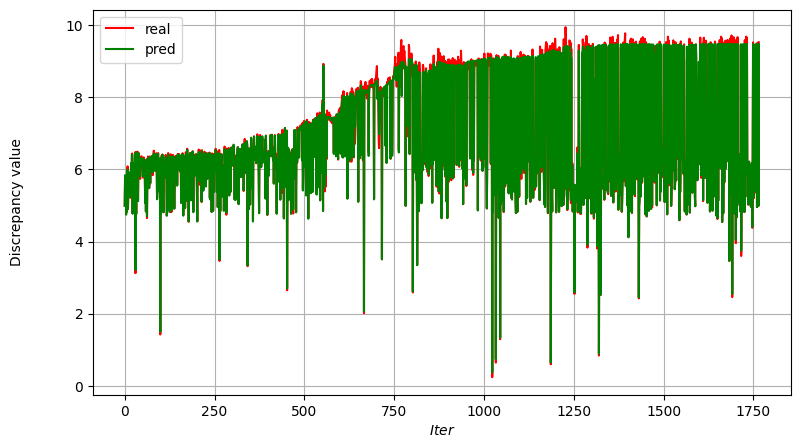

In [45]:
font_size_text = 10
fs=10


fig, axs = plt.subplots(1, 1, figsize=(9,5))
axs.plot(training_results[num_init_samples:,0]-num_init_samples, training_results[num_init_samples:,1], color='red', label='real')
axs.plot(training_results[num_init_samples:,0]-num_init_samples, training_results[num_init_samples:,2],'green',label='pred',)
axs.legend(fontsize=fs)
axs.grid()
axs.tick_params(axis='both', labelsize=fs)
axs.set_xlabel(r'$Iter$',fontsize=font_size_text)
axs.set_ylabel(r'Discrepancy value',fontsize=font_size_text,rotation='vertical',labelpad=30)


plt.show()

In [46]:
# Can skip the next two chuck for model replication
# cov_est_noise = np.loadtxt('mobolfi_em_2048iter_cov_est_noise_5.txt', dtype=np.dtype('float64'))

In [46]:
#estimate covaraince using the latest candidate
Y_cov = np.zeros((200,number_of_discrepancies))
index = np.argmax(training_results[:,-1])
X_cov = train_X[index,:].flatten().numpy()
for i in range(200):
    Y_cov[i,:] = minus_simluated_discrepancy(theta = ([X_cov[0],  real_theta[1]], real_theta[2],[X_cov[2],X_cov[3]],
                                                    [X_cov[1],real_theta[4]], X_cov[-1]),X_response=real_response)

cov_est_noise = np.cov(Y_cov, rowvar = False)

In [ ]:
cov_est_noise  

array(0.01032364)

In [48]:
# An optinal solution to find correlation between output dimensions (rt and ch)
# Estimate the correlation separately by applying covariance formula ot train_Y
cov_est_output = np.cov(train_Y, rowvar = False)
cov_est_output  # 3.94158841

array(3.94158841)

One thing worth to meantion is that the estimated covariance $Σ$, has small values. That suggest the 2 data courses (rt and ch) simulated by MLBA have noise uncorrelated from each other, i.e. the noise from 2 data sources come from 2 independent places.

As iteration goes, it is clear to see the predictive discrepancies values are decreasing and gradually going to the real data average, which is expected to see in theory.

But a good surrogate is not our ultimate target, we want "good" params that attain high likelihood values, and generate high similarity data, i.e. discrepancies very small.

So, the next step is to infer params and test their performance.

**Parameter inference and performance test**

After training the model, we need to compute the approximate posterior function. (See the original BOLFI paper)

Then, we need to draw MCMC sample parameters from the approximate posterior distribution. And draw plots of marginal posterior for each parameter.

Finally, we are going to test performance of parameter inference, by picking up a parameter point at high posterior density value, simluated multiple datasets given that parameter and present its similarity with real data.

In [ ]:
# Can skip the next two chuck for model replication
# tol = np.loadtxt('mobolfi_em_2048iter_1quantiletol_5.txt', dtype=np.dtype('float64'))

In [49]:
# The approximate likelihood is viewed as approximate posterior now,
# theta : (1*number_of_parameters) parameter point
# The likelihood approximate here is p(y_obs|theta), we have no means to compute likelihood for y!=y_obs, because GP model is trained by y_obs

tol = torch.quantile(train_Y,q=0.99,dim=0).tolist()# Test quantile tol level vs marginal posterior, approx ll is very sensitive to tol level!
print(tol)  #[9.618711471557617]


from scipy.stats import multivariate_normal

def approximate_log_likelihood(theta,tol=tol,cov_noise=cov_est_noise,gp=gp,covariance=0):
  theta = theta.view(1,-1)
  preds = gp.posterior(theta)
  means, variances = preds.mean, preds.variance
  means = means.view(-1).detach().numpy() * -1
  Sigma = np.array([variances[0].item()])
  cov_matrix = cov_noise + Sigma
  mulnorm = multivariate_normal(mean=means, cov=cov_matrix)
  log_likelihood = torch.Tensor([mulnorm.logcdf([-tol[0]])]).reshape(-1)
  return log_likelihood
# [3.473558187484741, 4.164658546447754]

[9.618711471557617]


In [50]:
real_theta_u =[real_theta[0]]#real_theta[0:1]
real_theta_u.append(real_theta[3])
real_theta_u.extend(real_theta[5:8])

real_theta_u #lamda1, delta1, beta,chi

[0.09404336, -0.8758533, 2.080699, 1.414022, 0.6108216]

In [51]:

approximate_log_likelihood(theta=torch.Tensor(real_theta_u).view(-1)) # should be large and larger than value of the chunk above

tensor([-169.9929])

In [52]:
lls = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    lls[i] = approximate_log_likelihood(param)

df_describe = pd.DataFrame(lls)
crt_median = df_describe.median()
print(df_describe.describe())
test_theta = train_X[np.argmax(lls),:]
test_theta 

c:\Users\e0729936\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_multivariate.py:862: RuntimeWarning: divide by zero encountered in log
  out = np.log(cdf)


                 0
count  2048.000000
mean          -inf
std            NaN
min           -inf
25%    -274.142799
50%    -203.077232
75%    -100.521450
max      -2.658866


tensor([ 0.0000, -1.1298,  2.6844,  1.6701,  1.2671])

The prior density is defined to be porduct of each marginal priors (assume parameters are indep).

However, the prior product is too small compared with approximate likelihood value. This is because the approximate likelihood function is merely proportional to real likelihood, we don't know the level of proximity to real likelihood. Thus, to enhance the voice of prior, we times a constant with the log prior density to make its values within the similar scale with approximate likelihood

In [53]:
print(real_theta_u)
print(test_theta )
# lam1,delta1,beta1,beta2,chi

[0.09404336, -0.8758533, 2.080699, 1.414022, 0.6108216]
tensor([ 0.0000, -1.1298,  2.6844,  1.6701,  1.2671])


In [54]:
lows_u_prior = [0, -3, -3,  -3,-2]
highs_u_prior = [5,5 , 5, 5, 6]

In [56]:
def log_prior(theta):# theta is 1d tensor
    
    lp = 0
    for i in range(theta.size()[0]):
        if theta[i]<lows_u_prior[i] or theta[i]>highs_u_prior[i]:
            lp = torch.Tensor([-1e12])[0]
            return torch.Tensor([-1e12])[0]
    
    
    
    return lp

In [57]:
#Test prior
priors = np.zeros(train_X.size()[0])
for i in range(train_X.size()[0]):
    param = train_X[i,:].view(-1)
    priors[i] = log_prior(param)

df_describe = pd.DataFrame(priors)
prior_median = df_describe.median()
df_describe.describe()


,0
count,2048.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [58]:
def approximate_log_posterior(theta):
  ll = approximate_log_likelihood(theta)
  lprior = log_prior(theta)
  lp = lprior + ll 
  lp = lp.float()
  return lp

In [59]:
print(approximate_log_posterior(theta=torch.Tensor(real_theta_u).view(-1)))
print(approximate_log_posterior(theta=torch.Tensor(test_theta).view(-1)))

# tensor([-156.3524])
# tensor([-2.4095])

tensor([-169.9929])
tensor([-2.6589])


In [60]:
test_theta = train_X[np.argmax(lls),:]
print(test_theta)
print(real_theta_u)

tensor([ 0.0000, -1.1298,  2.6844,  1.6701,  1.2671])
[0.09404336, -0.8758533, 2.080699, 1.414022, 0.6108216]


In [61]:
lows_u = [0, -3, -3, -3, -2]
highs_u = [5, 5, 5, 5, 6]

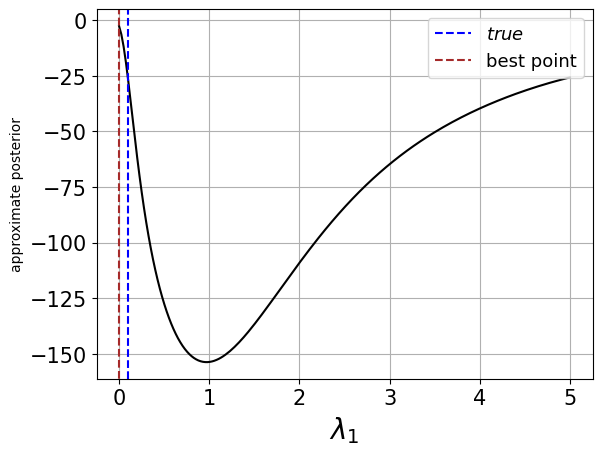

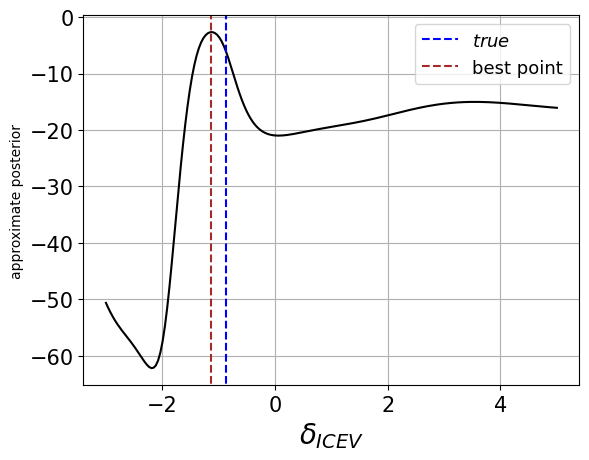

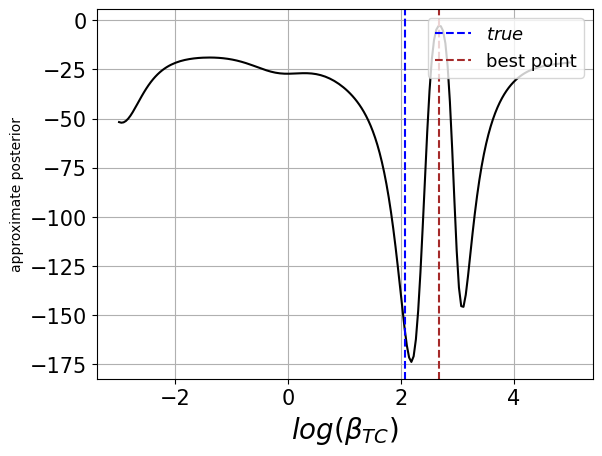

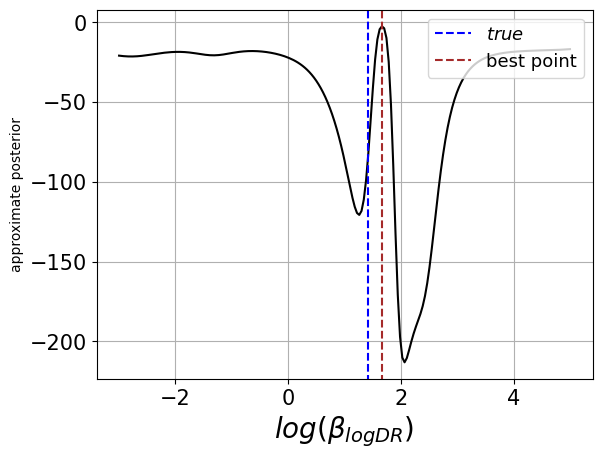

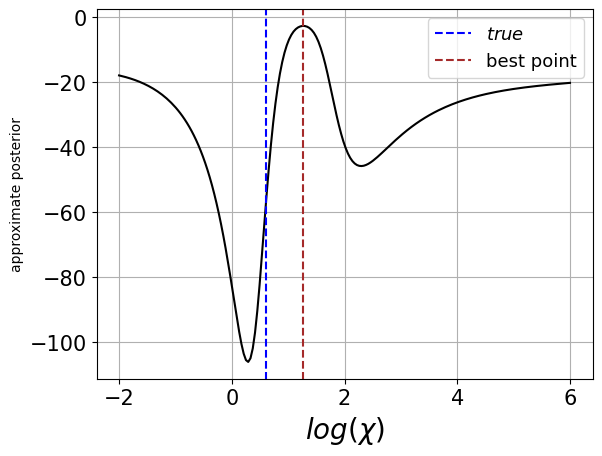

In [62]:
num_of_parameters = 5
import matplotlib.pyplot as plt 
import seaborn as sns

param_list = [r'$\lambda_1$',r'$\delta_{ICEV}$',r'$log(\beta_{TC})$',r'$log(\beta_{log DR})$',r'$log (\chi)$']
for param_index in range(num_of_parameters):
    shift_thetas = np.linspace(lows_u[param_index],highs_u[param_index], 200)

    shift_marlls = np.zeros(200)


    for i in range(200):
      
        tr_theta =list(test_theta)#list(real_theta_u) # list(last_chain_joint[0,:-1])
        tr_theta[param_index] = shift_thetas[i]
        shift_marlls[i] = approximate_log_posterior(torch.Tensor(tr_theta).view(-1)).item()
       
   
   
  
    

    plt.plot(shift_thetas,shift_marlls, color="black")
    plt.axvline( real_theta_u[param_index],lows_u[param_index],highs_u[param_index],linestyle="--",c='blue',label='$true$')
    plt.axvline(test_theta[param_index],-3,2,linestyle="--",c='brown',label = "best point")
        
 
        

    
    plt.legend()
    
    
    plt.legend(fontsize=13,loc='upper right')
    plt.grid()
    plt.tick_params(axis='both', labelsize=15)
    plt.xlabel(param_list[param_index],fontsize=20)
    plt.ylabel("approximate posterior")
    #plt.savefig('D:/onedrive/OneDrive - National University of Singapore/Desktop/MOBOLFI/result/MLBA_joint_'+param_name[param_index]+'.pdf',dpi = 1080,bbox_inches='tight') 

    plt.show()
  



DeMCMC

In [65]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scipy.stats import norm
import csv

class DEMCMC:

    def __init__(self, param_prior, param_hyper, post_fun, post_type,
                 param_num, chain_num, iter_num,
                 burn_in, migrate_rate, gamma, epsilon_b):
        """
        :param param_prior: a list of strings. list length should be the same as param_num.
                        Only two types prior distribution are available now.
                        "norm", for normal distribution prior.
                        "unif", for uniform distribution prior.
        :param param_hyper: a  (param_num,2) array. Entries are float type.
                        X[i,0] is the mean (or lower bound) of norm (uniform) distribution;
                        X[i,1] is the sd (or upper bound) of the norm (uniform) distribution;

        :param post_fun: a python function for posterior calculation

        :param post_type: bool type
                    post_type = 0, if the posterior returns from 0 to 1.
                    post_type = 1, if the posterior returns log-value.
        :param post_module: string
                    name of module contains the posterior function
        :param param_num: int type.
                    The number of estimable parameters. parameters with known fixed number were included.
        :param chain_num: int type.
                    The number of chains. When n<6,the chain_num = 24; otherwise, chain_num = 3*param_num.
        :param iter_num: int type.
                    The number of iteration.
        :param burn_in: int type.
                    The number of iteration for burn-in period. This part will discard for posterior sampling.
                    Moreover, migration step happens during burn-in period to facilitate convergence
        :param migrate_rate: float type. range from 0 to 1
                    The rate of migration step frequency during burn-in period.
        :param gamma: float type. A hyperparameter of De-MCMC crossover step. gamma = 2.38/sqrt(2*param_num)
        :param epsilon_b: float or vector type. A hyperparameter of De-MCMC crossover step. epsilon \sim uniform[-epsilon_b,epsilon_b]
        """

        self.param_num = param_num
        self.chain_num = chain_num
        self.iter_num = iter_num
        self.burn_in = burn_in
        self.migrate_rate = migrate_rate
        self.gamma = gamma
        self.epsilon_b = epsilon_b
        self.param_prior = param_prior
        self.param_hyper = param_hyper
        self.postfun = post_fun
        self.post_type = post_type


    def log_poster(self, theta):
        """
        :param theta: a list. input of posterior function
        :return: float type. the log-posterior for the dataset given input theta
        """
        
        # theta = torch.tensor(theta,dtype=torch.float32)
        
        if self.post_type:
            # log-posterior is directly used.
            res = self.postfun(theta)
            if np.isnan(res):
                res = -np.inf
                print("Warning: A log-posterior input is NaN. The system will drop it.")
            elif res < -1e11:
                res = -np.inf
                print("The log-posterior input is less than -1e11.")
        else:
            # log-posterior is calculated.
            if np.isnan(self.postfun):
                print("Warning: A posterior input is NaN. The system will drop it.")
                res = -np.inf
            elif self.postfun < 1e-16:
                print("The posterior input is less than 1e-16.")
                res = -np.inf
            else:
                res = np.log(self.postfun(theta))
        
        return np.float32(res)

    def draw_prior(self, num, prior, hyper):
        '''
        return the random draw from prior
        :param num: int type. the number of random samples.
        :param prior: a string,either "norm" or "unif"
        :param hyper: array(1,2).
                    hyper[0] = mean of norm distribution (or lower bound of uniform);
                    hyper[1] = sd of norm distribution (or upper bound of uniform);
        :return: an array (num,1).
        '''
        if prior == "norm":
            res = np.random.normal(loc=hyper[0], scale=hyper[1], size=num).astype(np.float32)
            # res = scipy.stats.truncnorm.rvs(a = (0-hyper[0])/hyper[1], b = (200-hyper[0])/hyper[1] , loc= hyper[0], scale=hyper[1],size = num)

        elif prior == "unif":
            res = np.random.uniform(low=hyper[0], high=hyper[1], size=num).astype(np.float32)
        else:
            print("error: the prior shape is unkown.")
            res = np.nan

        return np.float32(res)


    def initial_chains(self):
        """
        A function to return  for initial value
          :return: a list, whose first and only element is a (chain_num, param_num) matrix
        """
        # Initialize chains. The last column is for likelihood

        
        
        ###########################################################################
       
            
        # check input
        if (len(self.param_prior) != self.param_num) | (np.shape(self.param_hyper)[0] != self.param_num):
            print("error: The parameter prior or hyper input length is inconsistent with parameter number.")
            
        elif np.shape(self.param_hyper)[1] != 2:
            print("error: The dimension of hyperparameters are inconsistent with design, ",
                "please check `inital_chains` function for details.")
            
        else:
            theta_0 = np.zeros((self.chain_num, self.param_num + 1)).astype(np.float32)
            # calculate the log-posterior for chain_num parameter sets
            for i in range(self.param_num):
                    theta_0[:, i] = self.draw_prior(self.chain_num, self.param_prior[i], self.param_hyper[i, :]).tolist()
            
            
            for j in range(self.chain_num):
                theta_0[j,self.param_num] = self.log_poster(theta_0[j,:-1])
            

            index_p = [-1]*self.chain_num     
            index_p = np.where(((np.isinf(theta_0[:, self.param_num]))|(theta_0[:, self.param_num]<=(-1e11))).astype(int), range(self.chain_num), [-1]*self.chain_num)
            
        
            index = []
            for j in index_p:
                if j>=0:
                    index.append(j)

            while len(index) > 0:
                for i in range(self.param_num):
                    theta_0[index, i] = self.draw_prior(len(index), self.param_prior[i], self.param_hyper[i, :]).tolist()
                    # print(theta_0[i,self.param_num])
                    # calculate the log-posterior for chain_num parameter sets
                for j in index:
                    theta_0[j,self.param_num] = self.log_poster(theta_0[j, :-1])

                
                index_p = [-1]*self.chain_num
                index_p = np.where(((np.isinf(theta_0[:, self.param_num]))|(theta_0[:, self.param_num]<=(-1e11))).astype(int), range(self.chain_num), [-1]*self.chain_num)
                
                
                index = []
                for j in index_p:
                    if j >= 0:
                        index.append(j)
       
        return theta_0.astype(np.float32)


    def crossover_step(self, chain_index, last_step_chains):
        """
        For a given chain, randomly draw other two chains to get the difference value, the proposed value = chain_value + difference + epsilon
        :param chain_index: int type. The index of the updated chain at this step
        :param last_step_chains: A dataframe.
        :return: the value of chain of this step.It is a vector whose length is param_num+1.

        """
        # last_step_chains = last_step_chains
        # get the previous parameter values in this chain
        theta_prev = np.array(last_step_chains.iloc[chain_index, :-1])
        # Randomly draw two chain indices from all chains except the current chain
        prob = [1 / (self.chain_num - 1)] * self.chain_num
        prob[chain_index] = 0
        de_ChainIndex = np.random.choice(range(self.chain_num), size=2, replace=False, p=prob)

        theta_m = np.array(last_step_chains.iloc[de_ChainIndex[0], :-1])
        theta_n = np.array(last_step_chains.iloc[de_ChainIndex[1], :-1])

        # Generate new theta; here, there are npar parameters to estimate in total
        # epsilon = np.random.uniform(-self.epsilon_b, self.epsilon_b, self.param_num)
        
        epsilon = np.array([np.random.uniform(low, high, 1) for low, high in zip([-x for x in self.epsilon_b], self.epsilon_b)],dtype=np.float32).T

        
        theta_proposed = theta_prev + self.gamma * (theta_m - theta_n) + epsilon

        proposed_post = self.log_poster(theta_proposed)
        if np.isnan(proposed_post):  # avoid nan.
            proposed_post = -np.inf
        prev_post = last_step_chains.iloc[chain_index, self.param_num]

        # Acceptance rate
        alpha = np.random.uniform()
        ratio = proposed_post - prev_post
        if np.isnan(ratio):
            print("Warning: please check the initial matrix.")
            ratio = -1
        elif np.isinf(ratio) | (ratio <= -1e12):
            ratio = -1
        else:
            ratio = np.exp(ratio)
        if alpha > ratio:
            # reject the proposed value
            temp = np.append(theta_prev, prev_post)

        else:
            temp = np.append(theta_proposed, proposed_post)

        return temp.astype(np.float32)



    def migration_step(self, last_step_chains):

        """
        migration step is optional for De-MCMC, but very useful for the convergence.
        Normally, every 10 or 5 crossover steps during the burn-in stage, one migration step can be used.
        :param last_step_chains: A chain_num by (param_num +1) Dataframe.
         :return: A Dataframe, whose dimension is chain_num by (param_num +1). The last column is log-posterior value.
        """
        temp = last_step_chains 
        # select the migration scale, from 2 to chain_num
        mig_num = np.random.randint(low=2, high=self.chain_num)#+1
        # randomly draw mig_num chains for migration.
        mig_index = np.random.choice(a = range(self.chain_num), size=mig_num, replace=False)

        prev_theta = np.array(temp.iloc[mig_index, :-1])
        prev_post = temp.iloc[mig_index, -1].tolist()
        # epsilon = np.random.uniform(low=-self.epsilon_b, high=self.epsilon_b, size=(mig_num, self.param_num))
        epsilon = np.array([np.random.uniform(low, high, mig_num) for low, high in zip([-x for x in self.epsilon_b], self.epsilon_b)],dtype=np.float32).T
        for i in range(mig_num):
            if i != (mig_num - 1):  # not the last item
                proposed_theta = prev_theta[(i + 1), :] + epsilon[i, :]
            else:
                proposed_theta = prev_theta[0, :] + epsilon[i, :]

            proposed_post = self.log_poster(proposed_theta)
            if np.isnan(proposed_post):  # aviod nan.
                proposed_post = -np.inf
            # whether to accept
            alpha = np.random.uniform(low =0,high = 1,size = 1)
            ratio = proposed_post - prev_post[i]
            if np.isnan(ratio):
                print("Warning: please check the initial matrix.")
                ratio = -1
            elif np.isinf(ratio) | (ratio <= -1e12):
                ratio = -1
            else:
                ratio = np.exp(ratio)

            if alpha < ratio:  # accept the proposed value
                temp.iloc[mig_index[i], :] = np.append(proposed_theta, proposed_post)
            else:
                temp.iloc[mig_index[i], :] = np.append(prev_theta[i, :], prev_post[i])

        return temp.astype(np.float32)

    def De_MCMC(self,filename, setting = 1, last_chain = np.nan) -> list:
        """
        This functions to for De-MCMC sampling to return a chain trace list.
        setting: whether to start a new demcmc sampling.
        last_chain: array type. If setting =0, assignment the initial chain value here.
       :return: A file with (iter_num+1) elements, each element is a Dataframe has chain_num rows and param_num+1 columns.
       
        """
        # initial chain_list
        if setting == 1:
            chain_init = self.initial_chains()
            with open(filename, 'w') as file:
                for fm in range(self.chain_num):
                    file.write( '  '.join(map(str, chain_init[fm,:])) + '\n')
                file.close()
        else:
            chain_init = last_chain
    
      
                
                      
        print("initialization is finished.")
       
        chain_add = pd.DataFrame(chain_init,dtype=np.float32)  
        print(chain_add)
        for i in range(self.iter_num):
            chain_add = pd.DataFrame(Parallel(n_jobs= -4)(delayed(self.crossover_step)(row, chain_add) for row in range(self.chain_num)))
            
            # for j in range(self.chain_num):
                # chain_add1.iloc[j, :] = self.crossover_step(chain_index=j, last_step_chains=chain_add)
            if (i+1)%50 == 0:
                print(i+1, "iterations has been done.")
                print(chain_add)
            # chain_list.append(chain_add)
            if (i <= self.burn_in) & (np.random.uniform(low = 0,high =1,size = 1) < self.migrate_rate):
                # conduct migrate step
                chain_add = self.migration_step(chain_add)
                
            chain_add2 = chain_add.to_numpy(dtype=np.float32)
            with open(filename, 'a') as file:
                for fm in range(self.chain_num):
                    file.write( '  '.join(map(str, chain_add2[fm,:])) + '\n')
                file.close()
                    
            
        return 0

In [ ]:
param_num = 5
chain_num = 9
iter_num = 10000  
burn_in = 0#2000
migrate_rate =0.05# 0.3 - 0.7
gamma = 2.38 / np.sqrt(2 * param_num)  # suggested value
epsilon_b = [1e-3, 1e-3, 1e-3,1e-3,1e-3]
param_prior = ["unif", "unif", "unif", "unif", "unif"]


param_hyper = np.array([[0,5], [-3,5], [-3,5],[-3,5],[-2, 6]])
def myll(theta):
    
    theta = torch.tensor(theta,dtype=torch.float32).view(-1)
    ll = approximate_log_posterior(theta).float()
    # ll = 0
    return ll.item()


test_list = DEMCMC(param_prior=param_prior, param_hyper=param_hyper,
                post_fun=myll, post_type=1,
                chain_num=chain_num, param_num=param_num, iter_num=iter_num,
                burn_in=burn_in, migrate_rate=migrate_rate, gamma=gamma, epsilon_b=epsilon_b)


## if start a new MCMC sampling
# test_list.De_MCMC(filename="bolfi_crt_mcmc.txt",setting=1,last_chain=np.nan)
## if containue an existing MCMC sampling

demcmc_sample_list_bolfi = pd.read_csv("bolfi_crt_mcmc.txt",header=None,sep="  ", engine='python')
test_list.De_MCMC(filename="bolfi_crt_mcmc.txt",setting=0,last_chain=demcmc_sample_list_bolfi.tail(chain_num).to_numpy())



In [ ]:
chain_num = 9
demcmc_sample_list_bolfi = pd.read_csv("bolfi_crt_mcmc.txt",header=None,sep="  ", engine='python')

demcmc_sample_list_bolfi.tail(chain_num).to_numpy()

array([[  4.747297  ,  -2.4941964 ,   1.7635484 ,   3.2024298 ,
         -1.7860224 , -14.624291  ],
       [  0.74840325,  -0.9280278 ,  -0.72946197,   3.0079803 ,
          0.48776388, -20.85705   ],
       [  4.0716543 ,  -2.6649377 ,   0.7836525 ,   2.981675  ,
         -0.80692345, -15.923168  ],
       [  0.91778076,  -2.131863  ,  -0.11157146,   4.9238667 ,
          2.1447217 , -17.257027  ],
       [  4.591256  ,  -1.3415343 ,   3.4265237 ,  -2.9101796 ,
         -0.6986901 , -14.71159   ],
       [  3.544182  ,  -0.34759548,  -0.5291595 ,   4.801671  ,
          3.4039745 , -18.840218  ],
       [  4.644806  ,  -2.5016892 ,   0.9097591 ,   3.099251  ,
          0.52793354, -16.672182  ],
       [  0.48755383,  -2.2816408 ,   2.2472205 ,  -0.822533  ,
          0.6976512 , -17.808527  ],
       [  3.9189322 ,  -2.9446607 ,   0.8887721 ,   3.3763494 ,
         -1.1654992 , -16.402239  ]])

In [ ]:
# collect stationary chains
# num_of_parameters = 5
param_num =  num_of_parameters
chain_num = 9
iter_num_last = len(demcmc_sample_list_bolfi)/chain_num
print(iter_num_last)
coords_demcmc_bolfi_last = np.zeros((1, num_of_parameters+1))

# collect samples after stationary covergence
thin = random.sample(np.arange(int(5000),int(iter_num_last), 1).tolist(),k = 1000)
for i in thin:   
    sample = demcmc_sample_list_bolfi.iloc[(i*chain_num):((i+1)*chain_num),:]
    coords_demcmc_bolfi_last = np.concatenate((coords_demcmc_bolfi_last,sample),axis=0)
coords_demcmc_bolfi_last_dgn = demcmc_sample_list_bolfi.to_numpy()


10000.0


In [30]:
# demcmc sample for MOBOLFI for dignosis
# option: flatten over chains

# all iterations
chain_num = 9
coords_demcmc_dgn_last_bolfi = np.zeros((1, num_of_parameters+1))

for i in range(int(len(demcmc_sample_list_bolfi)/chain_num)):
    sample = np.zeros((chain_num+2, num_of_parameters+1))
    sample[0:chain_num,:] = demcmc_sample_list_bolfi.iloc[(i*chain_num):(i+1)*chain_num,:]
    sample[chain_num,:] = demcmc_sample_list_bolfi.iloc[(i*chain_num):(i+1)*chain_num,:].median()
    sample[chain_num+1,:] =  demcmc_sample_list_bolfi.iloc[(i*chain_num):(i+1)*chain_num,:].var()
    coords_demcmc_dgn_last_bolfi = np.concatenate((coords_demcmc_dgn_last_bolfi,sample),axis=0)


# iterations after stationary convergence
thin = random.sample(np.arange(int(5000),int(iter_num_last), 1).tolist(),k = 1000)
coords_demcmc_dgn_last_bolfi_sta = np.zeros((1, num_of_parameters+1))
for i in thin:
    sample = np.zeros((chain_num+2, num_of_parameters+1))
    sample[0:chain_num,:] = demcmc_sample_list_bolfi.iloc[(i*chain_num):(i+1)*chain_num,:]

    sample[chain_num,:] = demcmc_sample_list_bolfi.iloc[(i*chain_num):(i+1)*chain_num,:].median()
    sample[chain_num+1,:] =  demcmc_sample_list_bolfi.iloc[(i*chain_num):(i+1)*chain_num,:].var()
    coords_demcmc_dgn_last_bolfi_sta = np.concatenate((coords_demcmc_dgn_last_bolfi_sta,sample),axis=0)
    
    
    
    


In [ ]:
chain_num = 9

demcmc_sample_list = pd.read_csv("mobolfi_crt_em_mcmc.txt",header=None,sep="  ", engine='python')
print(demcmc_sample_list.tail(chain_num).to_numpy())
demcmc_sample_list_ch = pd.read_csv("mobolfi_chonly_em_mcmc.txt",header=None,sep="  ", engine='python')
print(demcmc_sample_list_ch.tail(chain_num).to_numpy())
demcmc_sample_list_rt = pd.read_csv("mobolfi_rtonly_em_mcmc.txt",header=None,sep="  ", engine='python')
print(demcmc_sample_list_rt.tail(chain_num).to_numpy())


[[ 1.2316272e-01 -2.5544033e+00  2.5238650e+00  1.4504680e+00
   7.0442590e-01 -7.9721484e+00]
 [ 5.1991053e-02 -1.7735131e+00  2.5563820e+00  1.5230849e+00
   7.2402890e-01 -7.5380240e+00]
 [ 3.9474647e-02 -2.2811747e+00  2.4074168e+00  1.4031888e+00
   6.4618840e-01 -6.0271590e+00]
 [ 5.1205143e-02 -2.5144668e+00  2.5899453e+00  1.4781958e+00
   8.7778610e-01 -7.7777700e+00]
 [ 1.0330050e-02 -2.3727643e+00  2.6738710e+00  1.2940806e+00
   7.3668070e-01 -9.1297530e+00]
 [ 6.9445215e-02 -2.2089832e+00  2.5703745e+00  1.8558631e+00
   8.7774500e-01 -9.0683690e+00]
 [ 1.0069837e-01 -2.0197200e+00  2.3653538e+00  1.4328455e+00
   7.3946140e-01 -6.4802340e+00]
 [ 2.8941142e-03 -1.9922113e+00  2.2325597e+00  1.6786374e+00
   7.9288566e-01 -8.7244340e+00]
 [ 4.2964880e-03 -2.6197815e+00  2.6443143e+00  1.7509370e+00
   1.0730997e+00 -9.7899950e+00]]
[[ 7.0599970e-02 -9.8069710e-01  1.3128444e+00  9.6131930e-01
   1.7581743e+00 -3.5913975e+00]
 [ 3.8185169e-03 -2.0254164e+00  2.2302630e+00  1

In [32]:
param_num =  num_of_parameters
chain_num = 9
iter_num_last = len(demcmc_sample_list)/chain_num
print(iter_num_last)
coords_demcmc_last = np.zeros((1, num_of_parameters+1))

# collect samples after stationary covergence
thin = random.sample(np.arange(int(47000),int(iter_num_last), 1).tolist(),k = 1000)
for i in thin:   
    sample = demcmc_sample_list.iloc[(i*chain_num):((i+1)*chain_num),:]
    coords_demcmc_last = np.concatenate((coords_demcmc_last,sample),axis=0)
coords_demcmc_last_dgn = demcmc_sample_list.to_numpy()

54973.0


In [33]:
param_num =  num_of_parameters
chain_num = 9

iter_num_last_ch = len(demcmc_sample_list_ch)/chain_num
coords_demcmc_ch_last = np.zeros((1, num_of_parameters+1))
print(iter_num_last_ch)
# collect samples after stationary covergence
thin = random.sample(np.arange(int(24000),int(iter_num_last_ch), 1).tolist(),k = 1000)
for i in thin:
    sample_ch =  demcmc_sample_list_ch.iloc[(i*chain_num):((i+1)*chain_num),:]
    coords_demcmc_ch_last = np.concatenate((coords_demcmc_ch_last,sample_ch),axis=0)


coords_demcmc_last_dgn_ch = demcmc_sample_list_ch.to_numpy()

27120.0


In [34]:
param_num =  num_of_parameters
chain_num = 9

iter_num_last_rt = len(demcmc_sample_list_rt)/chain_num
print(iter_num_last_rt)
coords_demcmc_rt_last = np.zeros((1, num_of_parameters+1))

# collect samples after stationary covergence
thin = random.sample(np.arange(int(30000),int(iter_num_last_rt), 1).tolist(),k = 1000)
for i in thin:
    sample_rt =  demcmc_sample_list_rt.iloc[(i*chain_num):((i+1)*chain_num),:]
    coords_demcmc_rt_last = np.concatenate((coords_demcmc_rt_last,sample_rt),axis=0)
coords_demcmc_last_dgn_rt = demcmc_sample_list_rt.to_numpy()

37877.0


In [ ]:
coords_demcmc_mlbaclosed = pd.read_csv('cf_em_crt_mcmc.csv', dtype=np.dtype('float64'))

coords_demcmc_mlbaclosed = pd.DataFrame(coords_demcmc_mlbaclosed)

coords_demcmc_mlbaclosed.shape


(15, 60006)

In [37]:
M = (coords_demcmc_mlbaclosed.shape[1])/(num_of_parameters+1)
M

10001.0

In [38]:

coords_demcmc_mlbaclosed = pd.DataFrame(coords_demcmc_mlbaclosed)
coords_demcmc_mlbaclosed.shape # number_chain * [(npar+1)
#(9, 56008)

tmp = []
i = 0

while i<M:
    tmp.append(pd.DataFrame(coords_demcmc_mlbaclosed.iloc[:,((num_of_parameters+1)*i):((num_of_parameters+1)*(i+1))].to_numpy(),columns = ['betaTC', "betaDR","zetaICEV","lam1","log_(b-A)","llk"])) 
    

    i +=1
M

10001.0

In [39]:
thin = random.sample(np.arange(int((5000)*1.5),int(M), 1).tolist(),k = 1000) #2700 samples
coords_demcmc_mlbaclosed = []
tmp1 = [tmp[index] for index in thin]
coords_demcmc_mlbaclosed = pd.concat(tmp1,ignore_index=True)

In [40]:
thin = np.arange(stop = int(M), step = 1).tolist()
coords_demcmc_mlbaclosed_dgn = []
tmp1 = [tmp[index] for index in thin]
coords_demcmc_mlbaclosed_dgn = pd.concat(tmp1,ignore_index=True)

In [41]:
coords_demcmc_mlbaclosed.describe()

,betaTC,betaDR,zetaICEV,lam1,log_(b-A),llk
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,2.076093,1.411053,-0.897800,0.093983,0.600629,-2502.088888
std,0.128740,0.089785,0.384172,0.027551,0.121866,1.681486
min,1.540053,1.039981,-2.387065,0.001869,0.039605,-2513.757079
25%,1.990946,1.350619,-1.156678,0.075850,0.524750,-2502.985876
50%,2.074663,1.406712,-0.882835,0.093535,0.608103,-2501.733384
75%,2.160974,1.469813,-0.637411,0.112204,0.686614,-2500.852647
max,2.577952,1.780414,0.431994,0.237007,0.954272,-2499.460744


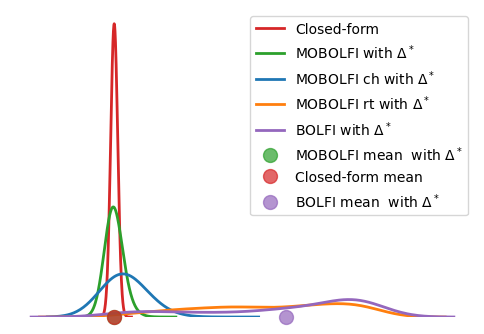

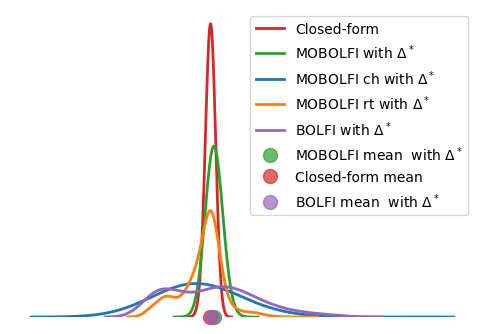

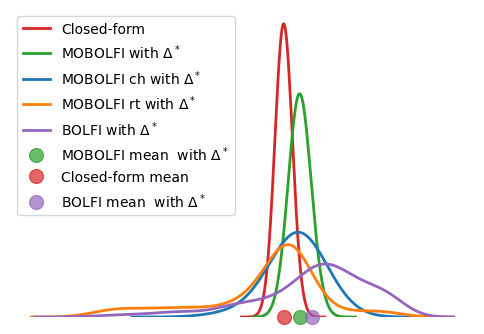

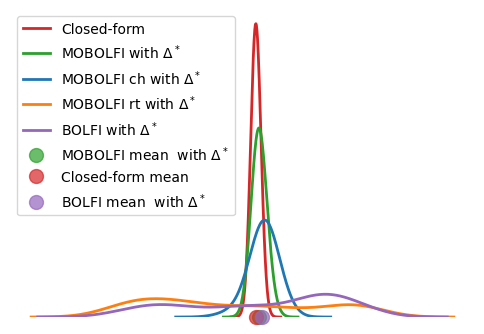

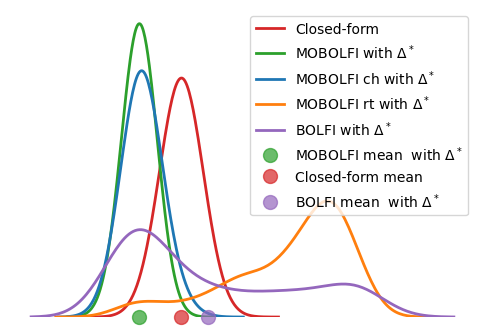

In [43]:
import seaborn as sns


font_size_text = 20
fs=10

param_list = [r'$\lambda_1$',r'$log (\chi-A)$',r'$log(\beta_{TC})$',r'$log(\beta_{DR})$',r'$\delta_{ICEV}$']

mobolfi_llk_index = [0,4,2,3,1]


# betaTC,betaDR,delta,lam1,zeta

closed_llk_index = [3,4,0,1,2]
point_coords_demcmc = coords_demcmc_last_dgn[1:,:]
point_coords_demcmc_rt = coords_demcmc_last_dgn_rt[1:,:]
point_coords_demcmc_ch = coords_demcmc_last_dgn_ch[1:,:]
point_coords_demcmc_cf = coords_demcmc_mlbaclosed_dgn
point_coords_demcmc_bolfi =  coords_demcmc_bolfi_last_dgn[1:,:]




index_joint = np.argmax(point_coords_demcmc[:,-1])
index_rt = np.argmax(point_coords_demcmc_rt[:,-1])
index_ch = np.argmax(point_coords_demcmc_ch[:,-1])
index_bolfi = np.argmax(point_coords_demcmc_bolfi[:,-1])
index_cf = np.argmax(point_coords_demcmc_cf.iloc[:,-1])
param_name = ["lam1","log_chi","log_betaTC","log_betaDR","deltaICEV"]
for i in range(num_of_parameters):
    plt.figure(figsize=[6, 4])
   
    
    if mobolfi_llk_index[i] ==1:
        sns.kdeplot(coords_demcmc_mlbaclosed.iloc[:,closed_llk_index[i]] , label='Closed-form',bw_adjust=10, color = "C3",linewidth=2)
        sns.kdeplot(coords_demcmc_last[1:,mobolfi_llk_index[i]], label='MOBOLFI with $\Delta^*$',bw_adjust=10, color = "C2",linewidth=2)#,clip = (-0.5,3))#,,clip = (lows_u1[mobolfi_llk_index[i]],highs_u1[mobolfi_llk_index[i]])
        sns.kdeplot(coords_demcmc_ch_last[1:,mobolfi_llk_index[i]], label='MOBOLFI ch with $\Delta^*$',bw_adjust=10, color = "C0",linewidth=2)#,clip = (-0.5,3))
        # sns.kdeplot(coords_demcmc_bolfi_last[1:,mobolfi_llk_index[i]], label='BOLFI with $\Delta^*$',bw_adjust=10, color = "C4",linewidth=2)#,clip = (-0.5,3))#,,clip = (lows_u1[mobolfi_llk_index[i]],highs_u1[mobolfi_llk_index[i]])
        
    elif mobolfi_llk_index[i] ==0:
        sns.kdeplot(coords_demcmc_mlbaclosed.iloc[:,closed_llk_index[i]] , label='Closed-form',bw_adjust=15, color = "C3",linewidth=2)
        sns.kdeplot(coords_demcmc_last[1:,mobolfi_llk_index[i]], label='MOBOLFI with $\Delta^*$',bw_adjust=10, color = "C2",linewidth=2)#,clip = (-0.5,3))#,,clip = (lows_u1[mobolfi_llk_index[i]],highs_u1[mobolfi_llk_index[i]])
        sns.kdeplot(coords_demcmc_ch_last[1:,mobolfi_llk_index[i]], label='MOBOLFI ch with $\Delta^*$',bw_adjust=10, color = "C0",linewidth=2)#,clip = (-0.5,3))
        # sns.kdeplot(coords_demcmc_bolfi_last[1:,mobolfi_llk_index[i]], label='BOLFI with $\Delta^*$',bw_adjust=10, color = "C4",linewidth=2)#,clip = (-0.5,3))#,,clip = (lows_u1[mobolfi_llk_index[i]],highs_u1[mobolfi_llk_index[i]])
   
    else:
        sns.kdeplot(coords_demcmc_mlbaclosed.iloc[:,closed_llk_index[i]] , label='Closed-form',bw_adjust=10, color = "C3",linewidth=2)
        sns.kdeplot(coords_demcmc_last[1:,mobolfi_llk_index[i]], label='MOBOLFI with $\Delta^*$',bw_adjust=10, color = "C2",linewidth=2)#,clip = (-0.5,3))#,,clip = (lows_u1[mobolfi_llk_index[i]],highs_u1[mobolfi_llk_index[i]])
        sns.kdeplot(coords_demcmc_ch_last[1:,mobolfi_llk_index[i]], label='MOBOLFI ch with $\Delta^*$',bw_adjust=10, color = "C0",linewidth=2)#,clip = (-0.5,3))
        # sns.kdeplot(coords_demcmc_bolfi_last[1:,mobolfi_llk_index[i]], label='BOLFI with $\Delta^*$',bw_adjust=10, color = "C4",linewidth=2)#,clip = (-0.5,3))#,,clip = (lows_u1[mobolfi_llk_index[i]],highs_u1[mobolfi_llk_index[i]])
   
            
    sns.kdeplot(coords_demcmc_rt_last[1:,mobolfi_llk_index[i]], label='MOBOLFI rt with $\Delta^*$',bw_adjust=2,color = "C1",linewidth=2)#,clip = (-0.5,3))
    sns.kdeplot(coords_demcmc_bolfi_last[1:,mobolfi_llk_index[i]], label='BOLFI with $\Delta^*$',bw_adjust=2, color = "C4",linewidth=2)#,clip = (-0.5,3))#,,clip = (lows_u1[mobolfi_llk_index[i]],highs_u1[mobolfi_llk_index[i]])
           
    plt.plot([coords_demcmc_last[:,mobolfi_llk_index[i]].mean()],[0],marker = 'o',ls = 'none',label='MOBOLFI mean  with $\Delta^*$',clip_on=False, color = "C2",alpha=.7,markersize = 10)
    # plt.plot([point_coords_demcmc[index_joint,mobolfi_llk_index[i]]],[0],marker = 's',ls = 'none',label='MOBOLFI MAP  with $\Delta^*$',clip_on=False, color = "C2",alpha=.5,markersize = 10)
    # plt.plot(real_theta_u[mobolfi_llk_index[i]],[0],marker = 's',ls = 'none',label='closed-form MAP',clip_on=False,color = "C3",alpha=.5,markersize = 10)
    plt.plot(coords_demcmc_mlbaclosed.mean().tolist()[closed_llk_index[i]],[0],marker = 'o',ls = 'none',label='Closed-form mean',clip_on=False,color = "C3",alpha=.7,markersize = 10)


    plt.plot([coords_demcmc_bolfi_last[:,mobolfi_llk_index[i]].mean()],[0],marker = 'o',ls = 'none',label='BOLFI mean  with $\Delta^*$',clip_on=False, color = "C4",alpha=.7,markersize = 10)
    # plt.plot([point_coords_demcmc_bolfi[index_bolfi,mobolfi_llk_index[i]]],[0],marker = 's',ls = 'none',label='BOLFI MAP  with $\Delta^*$',clip_on=False, color = "C4",alpha=.5,markersize = 10)
    
    plt.grid()
    plt.tick_params(axis='both', labelsize=15)
    plt.xlabel(param_list[i],fontsize=20)
    plt.ylabel("Density",fontsize=12)
    plt.axis('off')
    legend = plt.legend(fontsize=10)
   
    # plt.savefig('D:/onedrive/OneDrive - National University of Singapore/Desktop/MOBOLFI/result/2025_MLBA_em_post_MAP'+param_name[i]+'.pdf',dpi = 1080,bbox_inches='tight') 

    plt.show()







In [44]:
def export_legend(legend):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('D:/onedrive/OneDrive - National University of Singapore/Desktop/MOBOLFI/result/2025_MLBA_em_post_2_legend.pdf', dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()